# Final Project: Analysis of Concrete Data 
Name and UIN: - Katherine Sherhart (931005924) 
      - Alexandra McKillip (630003248)
      - Jasmine Garcia (132000177)
***

<b>Introduction </b> <br>
Concrete is one of the most widely used materials in construction. As a result, it is a frequently studied material in civil engineering. One of the most important properties of concrete is it's compressive strength. This notebook will seek to analyze and understand a dataset that contains information about different concrete mixtures and their resulting compressive strengths.

The dataset contains data on 1030 different concrete mixtures. For each of the concrete mixtures, there are eight different variables recorded that will be considered in the comparative analysis. The first seven variables are the "ingredients" or the amounts of cement, slag, ash, water, superplastic, coarse aggregate, and fine aggregate each measured in kilograms per cubic meter (kg/m^3). The eighth variable that is considered in the analysis is the age of the concrete mixture when it's set in days. The strength of the concrete, which is the response, is measured in MPa.

### Imports

In [ ]:
#Import Important Packages
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

#---------------------------------
# Packages for Forward Regression
from statsmodels.api import OLS
from l0bnb import fit_path
from ISLP.models import ModelSpec as MS, Stepwise, sklearn_selected, sklearn_selection_path, summarize
from functools import partial

import sklearn.linear_model as skl
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from ISLP.models import sklearn_sm
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

#---------------------------------
# Packages for Naive Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from ISLP import confusion_table
from sklearn.model_selection import cross_val_score

#---------------------------------
#Packages for Tree Classification 
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP.bart import BART

from matplotlib.pyplot import subplots
import sklearn.model_selection as skm


#---------------------------------
#Packages for KNN
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Descriptive Statistics

<b>Descriptive Statistics Analysis</b> <br> 
The first attribute of this dataset that stands out is the significant number of concrete mixtures that don't contain either ash, slag, or superplastic. At least half of the observations don't contain ash, as depicted by its 50th percentile value, and at least a quarter of the observations don't contain slag or superplastic, as depicted by each of their 25th percentile values. On the other hand, cement, water, coarse aggregate, and fine aggregate are always present in the mixture. Both the coarse and fine aggregates tend to make up the largest part of the mixtures as seen by their high mean values. The next most prevalent ingredients tend to be water and cement. This makes sense as traditional concrete is composed of cement, water, and aggregate.

The compressive strength has a wide range of 80.27 MPa, so the ingredients have a definite impact on compressive strength.

Cement seems to vary the most as seen by its high standard deviation of 104.506 and wide range of 438. Most of the mixtures are no more than two months old as seen that the 75th percentile for age is 56 days.


In [1053]:
# Read in the concrete.csv into a Data Frame
concrete_data = pd.read_csv('concrete.csv')

In [1055]:
# Retrieve Descriptive Statistics
concrete_data.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [1057]:
# Retrieve Predictor Variable Ranges 
ranges = {col: (concrete_data[col].min(), concrete_data[col].max()) for col in list(concrete_data.columns)}
print("Ranges of quantitative predictors:")

P_ranges = {
    "Name" :ranges.keys(),
    "Min": [value[0] for value in ranges.values()],
    "Max": [value[1] for value in ranges.values()],
    "Range Width": [value[1]-value[0] for value in ranges.values()]
}

p_ranges_table = pd.DataFrame(P_ranges)
print(p_ranges_table.to_string(index = False))

Ranges of quantitative predictors:
        Name    Min    Max  Range Width
      cement 102.00  540.0       438.00
        slag   0.00  359.4       359.40
         ash   0.00  200.1       200.10
       water 121.80  247.0       125.20
superplastic   0.00   32.2        32.20
   coarseagg 801.00 1145.0       344.00
     fineagg 594.00  992.6       398.60
         age   1.00  365.0       364.00
    strength   2.33   82.6        80.27


<b>Descriptive Statistics Analysis - Histograms</b> <br> 
The histograms of slag, ash, and superplastic support the earlier stated observation that there is a large number of mixtures that contain none or very low amounts of slag, ash and superplastic. It also seems that of these three additive ingredients, superplastic is used in smaller quantities.
The histograms of cement, coarse aggregate, and fine aggregate show that the distribution of each of these ingredients is relatively normal. The histogram of age also supports the earlier stated observation that most of the concrete mixtures are 2-3 months old or less when they are used.


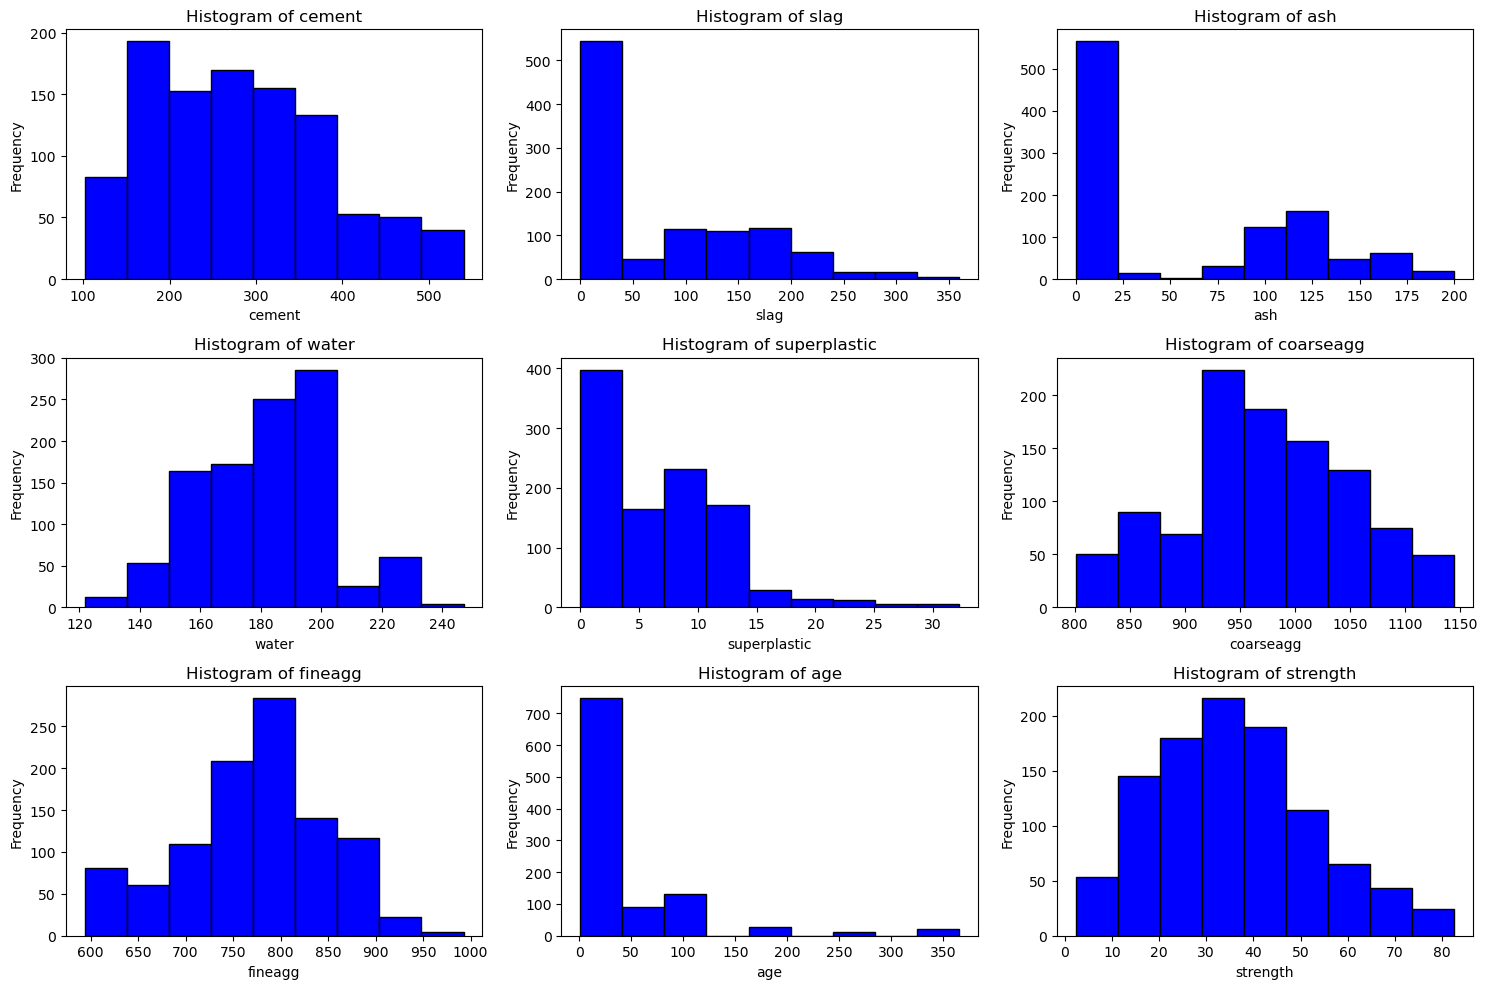

In [1060]:
# Plot Histograms of Each Predictor Variable and the Compressive Strength Output

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.ravel()  # Flattens the 2D array to make indexing in the loop easier

for i, col in enumerate(concrete_data.columns):
    axes[i].hist(concrete_data[col], bins=9, color='blue', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Automatically spacing of subplots such that there is no overlap
plt.tight_layout()
plt.show()

<b>Descriptive Statistics Analysis - Scatter Plots</b> <br> 
Out of the eight scatter plots that show each individual variable of the concrete mixture compared to the resulting compressive strength of the mixture, the amount of cement and superplastic, if used, seems to be the most positively correlated with the resulting compressive strength. Additionally, the cement data seems to exhibit heteroskedasticity as the data follows an expanding funnel shape where there is less variability in compressive strength for lower values of cement and more variability in  compressive strength for higher values of cement.
Out of the eight scatterplots, the amount of water used in the concrete mixture seems to be the most likely variable to be negatively correlated with the resulting compressive strength. 
One subtle observation about the age scatterplot is that it seems that the age of the concrete results in peak values for the compressive strength between about 25 and 100 days. Mixtures that are younger than around 25 days seem to have lower compressive strengths and mixtures that are older than 100 days seem to have decreasing values of compressive strength.
The rest of the variables' scatter plots, slag, ash, coarse aggregate, and fine aggregate, don't reveal any meaningful relationships via these graphs.


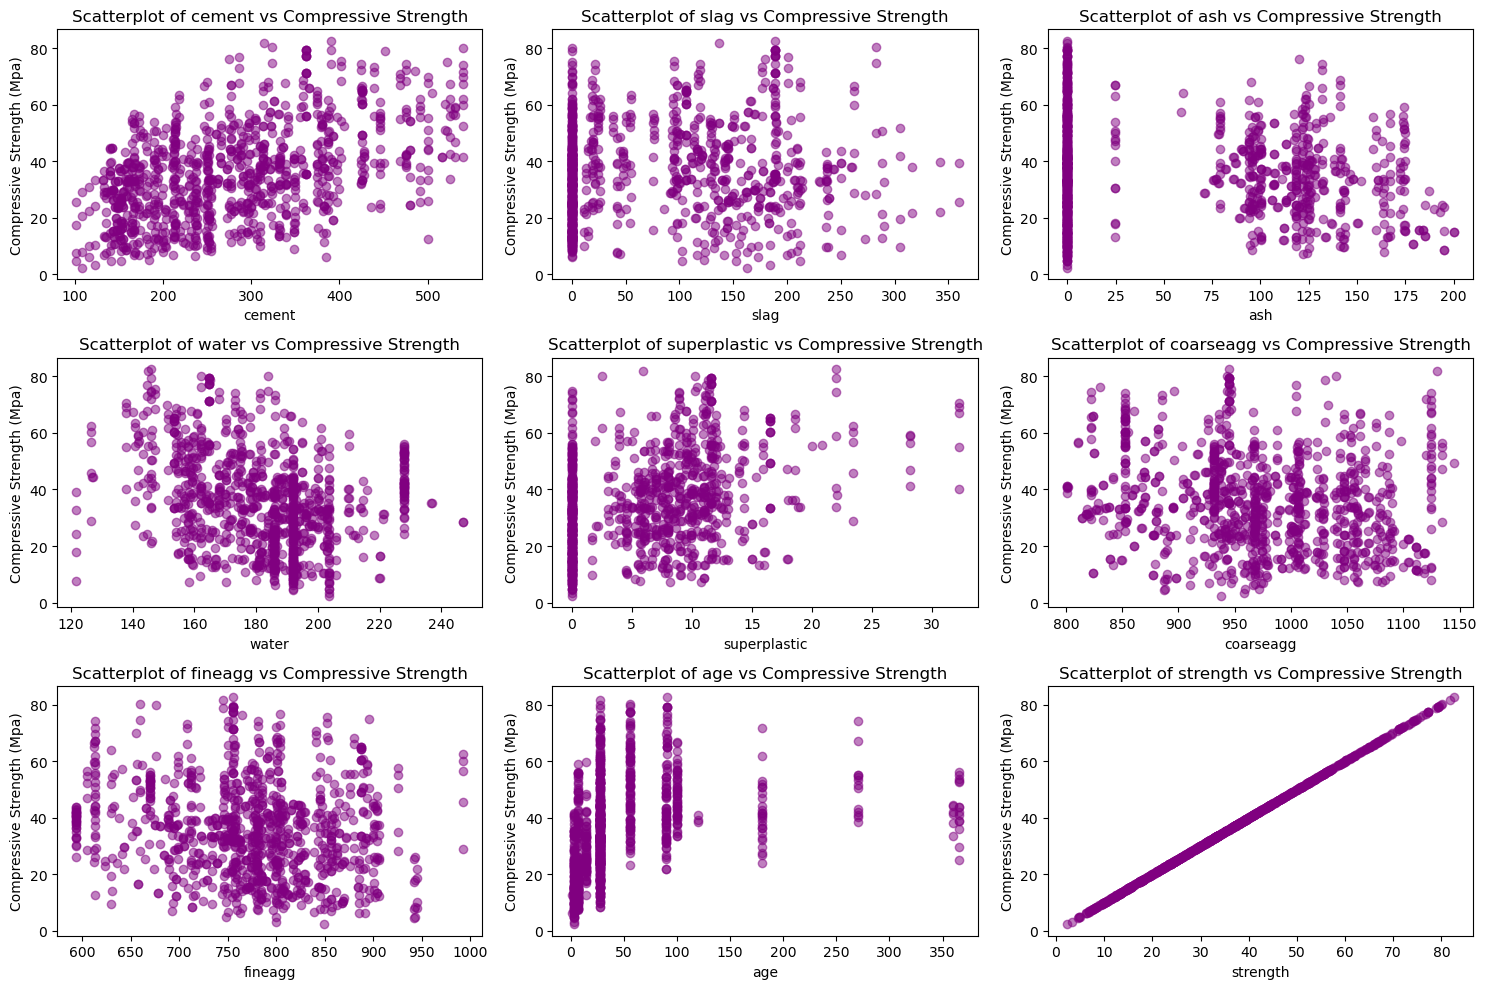

In [1062]:
# Plot Scatterplots of Each Predictor Variable versus the Compressive Strength Output
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.ravel()  # Flattens the 2D array to make indexing in the loop easier

for i, col in enumerate(concrete_data.columns):
    axes[i].scatter(concrete_data[col], concrete_data['strength'], alpha=0.5, color='purple')
    axes[i].set_title(f'Scatterplot of {col} vs Compressive Strength')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Compressive Strength (Mpa)')

# Automatically spacing of subplots such that there is no overlap
plt.tight_layout()
plt.show()

## Predictive Analysis: Regression 

<b> Ordinary Least Squares Method with Predictors Choosen by Forward Stepwise Selection <b>

OLS regression with predictors chosen by forward stepwise is highly interpretable. Stepwise selection is easy to visualize and understand. The results of regression are easy to interpret. The magnitude of the slope coefficients indicates the relative impact of each ingredient on the strength of the concrete, while the sign of the coefficients shows the direction of their relationship with the response.

In [1066]:
# Define Cp statistic function
def nCp(sigma2,estimator,X,Y):
    "Negative Cp statistic" # cross validation prediction error
    n,p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y-Yhat)**2)
    return -(RSS+2*p*sigma2)/n

In [1067]:
# Forward subset selection
Xs = MS(concrete_data.columns.drop('strength')).fit(concrete_data)
Y = np.asarray(concrete_data['strength'])
X = Xs.transform(concrete_data)
sigma2 = OLS(Y,X).fit().scale

neg_Cp = partial(nCp, sigma2)


In [1068]:
# set the strategy to be forward
strategy = Stepwise.first_peak(Xs,
                               direction = 'forward',
                               max_terms=len(Xs.terms))

In [1070]:
# Compare the different models via their individual Cp Scores
concrete_Cp = sklearn_selected(OLS, strategy, scoring = neg_Cp)
concrete_Cp.fit(concrete_data,Y)
concrete_Cp.selected_state_

('age', 'ash', 'cement', 'slag', 'superplastic', 'water')

In [1071]:
#Fitting regression with predictors chosen by forward stepwise selection above
X = MS(concrete_data.columns.drop(['strength', 'coarseagg', 'fineagg'])).fit_transform(concrete_data)
model = sm.OLS(Y,X)
results = model.fit()
summarize(results)

,coef,std err,t,P>|t|
intercept,28.9930,4.213,6.881,0.000
cement,0.1054,0.004,24.825,0.000
slag,0.0865,0.005,17.385,0.000
ash,0.0687,0.008,8.877,0.000
water,-0.2181,0.021,-10.322,0.000
superplastic,0.2403,0.085,2.842,0.005
age,0.1135,0.005,20.988,0.000


In [1072]:
# this cell produces the test MSE
hp_model = sklearn_sm(sm.OLS)
cv_results = cross_validate(hp_model,
                            X,
                            Y,
                            cv=concrete_data.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err

109.57940033069418

Using the forward stepwise subset selection method restricts the number of predictors that are included in the model. The predictors chosen by applying forward stepwise selection are age, ash, cement, slag, superplastic, and water. The positive coefficients in the model were cement, slag, ash, superplastic, and age. The sole negative coefficient in the model was for water. The coefficient for the cement can be interpreted as increasing the density of cement by one $kg/m^3$ increases the strength of the concrete by $0.1054 MPa$ .This same logic follows for the rest of the predictors and their respective coefficients.


<b>Ordinary Least Squares Method with Predictors Choosen by LASSO <b>


LASSO regression involves a more complex process than pure OLS regression in determining the predictors to include in the model and their resulting slope coefficients; however, the model is more interpretable when LASSO is used because it eliminates a handful of the predictors that are less influential. In the model that used LASSO the coarse aggregate and fine aggregate were not considered. These variables make sense to exclude because they main purpose is to create volume in concrete.


In [1076]:
# set up our lasso data
#'binary_strength' if you run the model again and get issues add this to the columns that are dropped
design = MS(concrete_data.columns.drop(['strength'])).fit(concrete_data)
Y = np.array(concrete_data['strength'])
D = design.fit_transform(concrete_data)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [1077]:
# we first fit a path to Lasso 
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs,
                                 Y,
                                 l1_ratio=0,
                                 alphas=lambdas)[1]
soln_array.shape

(8, 100)

In [1078]:
#this cells allows use to see the regularization paths table 
# this output will also be used for the plot
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age
negative log(lambda),,,,,,,,
-15.605414,0.000001,3.759186e-07,-2.948561e-07,-8.075292e-07,0.000001,-4.598555e-07,-4.662867e-07,9.169335e-07
-15.372830,0.000002,4.743554e-07,-3.720662e-07,-1.018986e-06,0.000001,-5.802718e-07,-5.883871e-07,1.157039e-06
-15.140245,0.000002,5.985686e-07,-4.694942e-07,-1.285815e-06,0.000002,-7.322199e-07,-7.424602e-07,1.460017e-06
-14.907661,0.000003,7.553079e-07,-5.924344e-07,-1.622514e-06,0.000002,-9.239566e-07,-9.368785e-07,1.842333e-06
-14.675077,0.000004,9.530904e-07,-7.475673e-07,-2.047380e-06,0.000003,-1.165901e-06,-1.182206e-06,2.324760e-06
...,...,...,...,...,...,...,...,...
6.490100,12.241681,8.690987e+00,5.387462e+00,-3.381150e+00,1.748749,1.221402e+00,1.379887e+00,7.188265e+00
6.722684,12.296200,8.744213e+00,5.434953e+00,-3.345238e+00,1.747763,1.258062e+00,1.427340e+00,7.193100e+00
6.955268,12.340141,8.787115e+00,5.473224e+00,-3.316160e+00,1.747045,1.287677e+00,1.465652e+00,7.196957e+00


In [1079]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

scaler = StandardScaler(with_mean=True,  with_std=True)


# perform lasso using ElasticNetCV
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)


Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso',
                 ElasticNetCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=1))])

In [1080]:
# this cell return the alpha 
# this values being very small indicated there is fewer variables that need to be set to zero. 
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.06742617008912771

In [1081]:
# want to find the lasso paths 
lambdas, soln_array = skl.Lasso.path(Xs, 
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]

# put the lasso path into a data frame in order to be able to plot
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

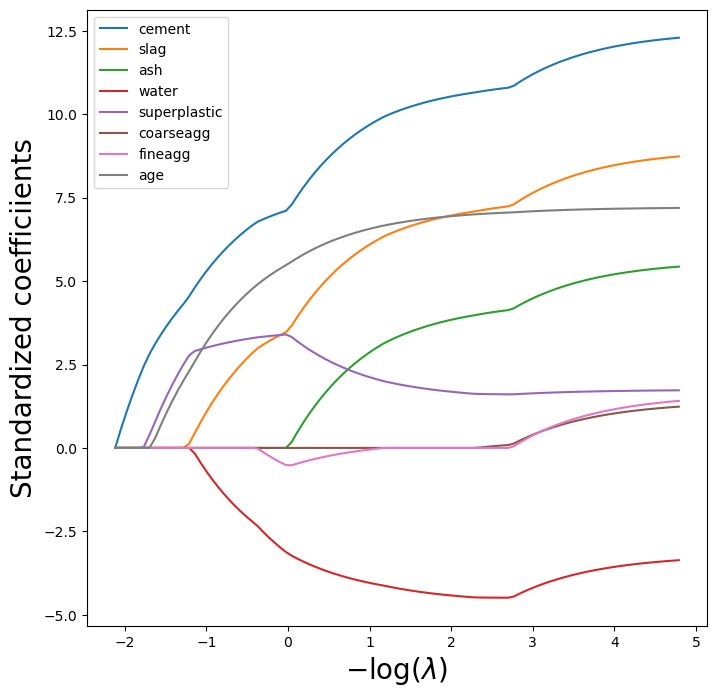

In [1083]:
# this cell plots the lasso path to help visualize the variable coefficients
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

In [1087]:
# find the minimum mean squared error
np.min(tuned_lasso.mse_path_.mean(1))

111.91120261841141

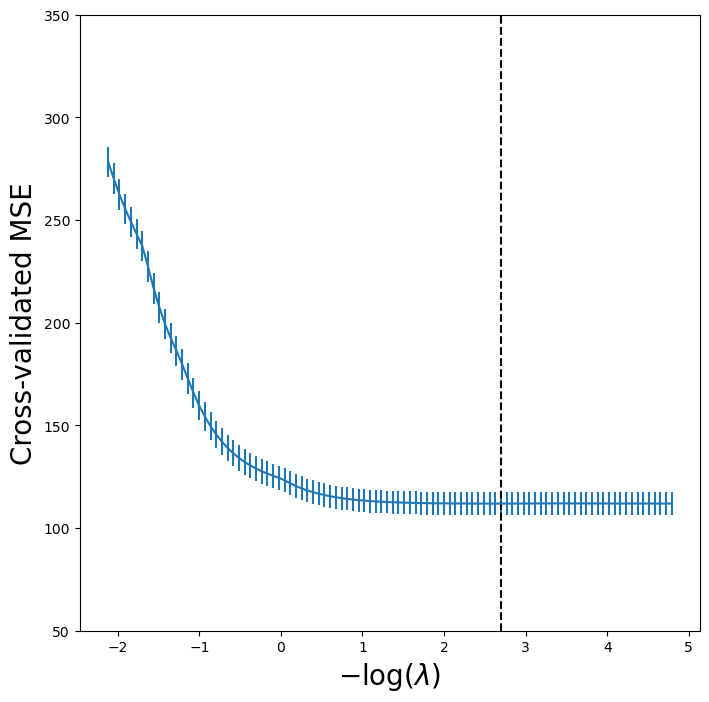

In [1090]:
# plot a visual representation of the cross-validated MSEs
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([50,350])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

Here we see that 1 of the 8 coefficient estimates is exactly 0 and a 2nd coefficient estimate is very close to being 0.  

In [1092]:
# this cell prints out the coefficients of each variable
tuned_lasso.coef_

array([10.7951167 ,  7.23928361,  4.12951253, -4.48930916,  1.60589636,
        0.08613763,  0.        ,  7.0531713 ])

The regularization path table showed an increase in negative log of lambda and its respective coefficient with each of the eight variables. It can be noted that the coefficient for most of the variables also increase. It can also be noted that the regularization parameter is $0.06742$ indicating that the is less regularization needed. The minimum mean squared error is $111.9$ which corresponds to the optimal regularization parameter found earlier. Lastly, the coefficients of the variables are found. The positive coeffients of cement, slag, ash, superplastic, coarseagg, and age indicate that there is a positive relationship between the addition of one unit each of these six variables that cause an increase in the strength of concrete. The negative coefficient of water indicated that there is a negative relationship between that addition of one unit of water and the strength of concrete. The zero coefficient of fineagg means that there is no significant relationship with the strength of the concrete. 

## Predictive Analysis: Classification

Classification is a technique that is used to identify the qualitative response of a given data set. In this lab, the classification of the strength being above or below 40 MPa is imperative. To evaluate the data, Naive Bayes and Regression Trees are performed. <br>

A new variable 'binary_strength' is created to classify the observation as  $0$ if it is below 40 MPa and as $1$ if the observation is above 40 MPa.


In [1097]:
# The imposed threshold for a "passing" compressive strength is 40 MPa
threshold = 40.0
concrete_data['binary_strength']= concrete_data['strength'].apply(lambda x: 1 if x > threshold else 0)

In [1101]:
#split into testing and training data- we used an 80/20 split
concrete_train = concrete_data.loc[:824]
concrete_test = concrete_data.loc[825:]
concrete_train.shape
concrete_test.shape


(205, 10)

<b>Naive Bayes<b>

Naive Bayes is fairly interpretable but less so than regression and tree models. Its assumption of independence simplifies the model.


In [1107]:
# define the X and Y varibales in our data
X = MS(concrete_data.columns.drop(['strength', 'binary_strength'])).fit_transform(concrete_data)
y = concrete_data['binary_strength']

# divide the data into training and testin by 
X_train, X_test = X.loc[:824], X.loc[825:]
y_train, y_test = y.loc[:824], y.loc[825:]
D = concrete_data.binary_strength
L_train, L_test = D.loc[:824], D.loc[825:]

# need to drop the intercept ot only find probability of the needed features 
X_train, X_test = [M.drop(columns=['intercept'])
                   for M in [X_train, X_test]]


In [1109]:
NB = GaussianNB()
NB.fit(X_train, L_train)


GaussianNB()

In [1111]:
# this cell shows the 2 distict classes that are in the data 
# the two classes are below 40 MPa and above 40 MPa
NB.classes_

array([0, 1], dtype=int64)

In [1112]:
# this cell show the probability of each class respectively, [0,1]
NB.class_prior_

array([0.64484848, 0.35515152])

In [1113]:
# this cell will result in an array of equal length of the number of classes and the number of columns equal to 
# the number of predicto

#first array is avg value of each parameter when strength is below 40 mPa
#second array is avg value of each parameter when strength is above 40 mPa
NB.theta_

array([[246.84379699,  69.24642857,  57.99924812, 185.35      ,
          4.84078947, 980.58834586, 782.75921053,  29.22556391],
       [339.91331058,  78.49283276,  45.61228669, 176.35255973,
          8.09556314, 964.22901024, 756.72320819,  75.06484642]])

In [1116]:
# this cell return the variance
NB.var_

array([[ 7927.5404424 ,  7923.25670873,  4324.74910814,   331.60491697,
           25.95580958,  5713.21833378,  5490.64618552,  1939.97920707],
       [10872.05795665,  6311.16484013,  3500.64866546,   618.68933034,
           45.24534963,  6611.9469168 ,  7801.72083752,  6112.50433832]])

In [1117]:
# this cell will verify that the mean computation performmed earlier are right
# mean computaiton for observations below 40 mPa
X_train[L_train == 0].mean()

cement          246.843797
slag             69.246429
ash              57.999248
water           185.350000
superplastic      4.840789
coarseagg       980.588346
fineagg         782.759211
age              29.225564
dtype: float64

In [1120]:
# this cell will verify that the variance that was found earlier is correct
#variance for observations  below 40 mPa
X_train[L_train == 0].var(ddof=0)

cement          7927.540431
slag            7923.256698
ash             4324.749097
water            331.604906
superplastic      25.955799
coarseagg       5713.218323
fineagg         5490.646175
age             1939.979196
dtype: float64

In [1121]:
X_train[L_train == 1].mean()

cement          339.913311
slag             78.492833
ash              45.612287
water           176.352560
superplastic      8.095563
coarseagg       964.229010
fineagg         756.723208
age              75.064846
dtype: float64

In [1127]:
X_train[L_train == 1].var(ddof=0)

cement          10872.057946
slag             6311.164829
ash              3500.648654
water             618.689319
superplastic       45.245339
coarseagg        6611.946906
fineagg          7801.720827
age              6112.504327
dtype: float64

In [1132]:
#73% accuracy
nb_labels = NB.predict(X_test)
confusion_table(nb_labels, L_test)

Truth,0,1
Predicted,,
0,104,41
1,15,45


In [1134]:
# this cell prints how accurate the naive bayes is 
(104 + 45)/ (104+41+15+45)

0.7268292682926829

In [1137]:
# this cell shows the first 5 outcome of the prediciton probabilities of both classes[0,1]
NB.predict_proba(X_test)[:5]

array([[0.77285015, 0.22714985],
       [0.8092928 , 0.1907072 ],
       [0.91038972, 0.08961028],
       [0.71516515, 0.28483485],
       [0.96950494, 0.03049506]])

Naive Bayes is used to categorize observations as having above 40 MPa or less than 40 MPa of compressive strength. The data is divided into  training and testing sets. It’s determined that 64.48% of the observations in the training data have a compressive strength of 40 MPa or less and 35.52% of the observations have a compressive strength above 40 MPa. After we fit the model according to the training observations, we predict classifications of the test observations. Finally a confusion table is used to determine the accuracy of the model. The Naive Bayes model resulted in a 72.68% accuracy rate in predicting the correct category for the test observations. 

<b> Tree Classification <b>

The tree models have limited interpretability because the tree has many branches even with the implementation of pruning. However their visual layout assists with showing how they perform decision making and arrive at their conclusions.


In [1142]:
# The imposed threshold for a "passing" compressive strength is 40 MPa
#threshold = 40.0
#concrete_data['binary_strength']= concrete_data['strength'].apply(lambda x: 1 if x > threshold else 0)

strong = np.where(concrete_data['strength'] > 40, "Yes", "No")
X = MS(concrete_data.columns.drop(['strength', 'binary_strength'])).fit_transform(concrete_data)
y = concrete_data['binary_strength']

feature_names = list(X.columns)
X = np.asarray(X)

clf = DTC(criterion = 'entropy', 
          max_depth = 4,
         random_state = 0)

clf.fit(X, strong)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)

In [1144]:
# this cell output the accuracy of the observation being strong(above 40 MPa)
accuracy_score(strong, clf.predict(X))

0.8631067961165049

In [1146]:
# this cell outputs the cumm of the logarithmic loss
resid_dev = np.sum(log_loss(strong, clf.predict_proba(X)))
resid_dev

0.29435253670502676

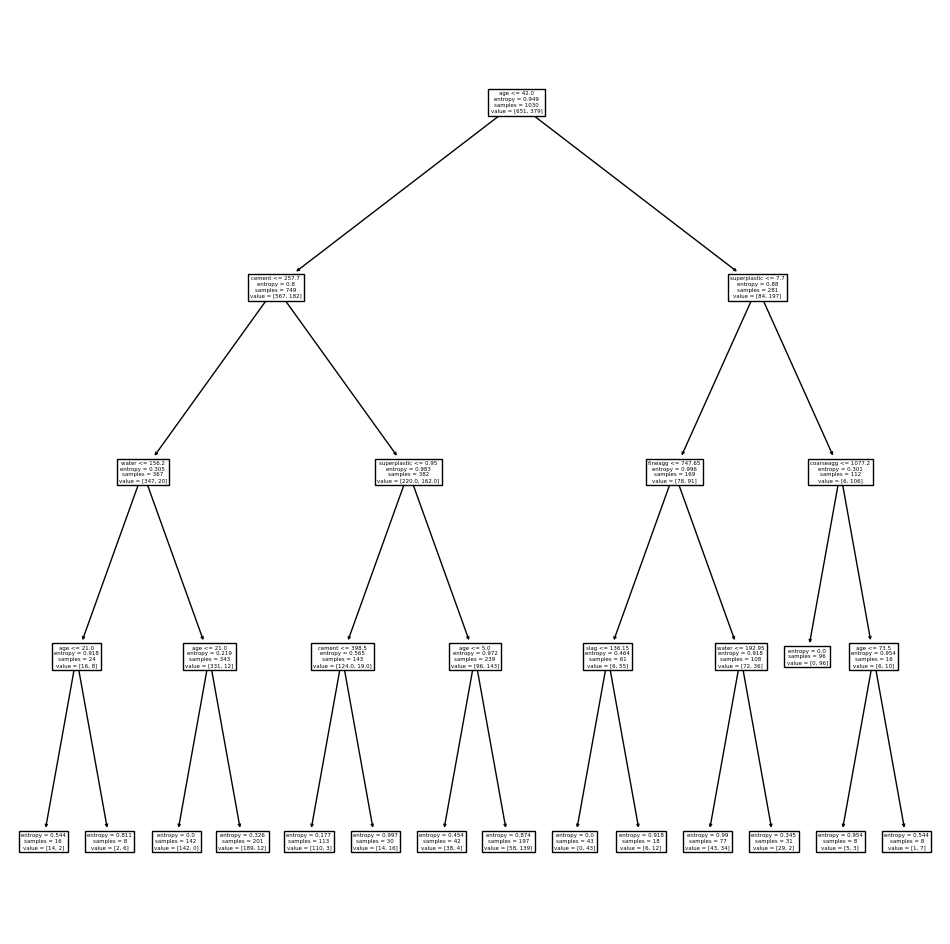

In [945]:
# this cell outputs the visual image of the tree analysis
ax = subplots(figsize=(12,12))[1]
plot_tree(clf,
          feature_names=feature_names,
          ax=ax);


In [1148]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))



|--- age <= 42.00
|   |--- cement <= 257.70
|   |   |--- water <= 156.20
|   |   |   |--- age <= 21.00
|   |   |   |   |--- weights: [14.00, 2.00] class: No
|   |   |   |--- age >  21.00
|   |   |   |   |--- weights: [2.00, 6.00] class: Yes
|   |   |--- water >  156.20
|   |   |   |--- age <= 21.00
|   |   |   |   |--- weights: [142.00, 0.00] class: No
|   |   |   |--- age >  21.00
|   |   |   |   |--- weights: [189.00, 12.00] class: No
|   |--- cement >  257.70
|   |   |--- superplastic <= 0.95
|   |   |   |--- cement <= 398.50
|   |   |   |   |--- weights: [110.00, 3.00] class: No
|   |   |   |--- cement >  398.50
|   |   |   |   |--- weights: [14.00, 16.00] class: Yes
|   |   |--- superplastic >  0.95
|   |   |   |--- age <= 5.00
|   |   |   |   |--- weights: [38.00, 4.00] class: No
|   |   |   |--- age >  5.00
|   |   |   |   |--- weights: [58.00, 139.00] class: Yes
|--- age >  42.00
|   |--- superplastic <= 7.70
|   |   |--- fineagg <= 747.65
|   |   |   |--- slag <= 136.15
|   | 

print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))


In [1150]:
validation = skm.ShuffleSplit(n_splits=1,
                              test_size=824,
                              random_state=0)
results = skm.cross_validate(clf,
                             X,
                             strong,
                             cv=validation)
results['test_score']


array([0.80825243])

In [1152]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                strong,
                                test_size=0.3,
                                random_state=0)

In [1154]:
clf = DTC(criterion='entropy',random_state=0)
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.919093851132686

In [1156]:
ccp_path = clf.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(10,
                  random_state=1,
                  shuffle=True)
grid = skm.GridSearchCV(clf,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')
grid.fit(X_train, y_train)
grid.best_score_

0.8765981735159818

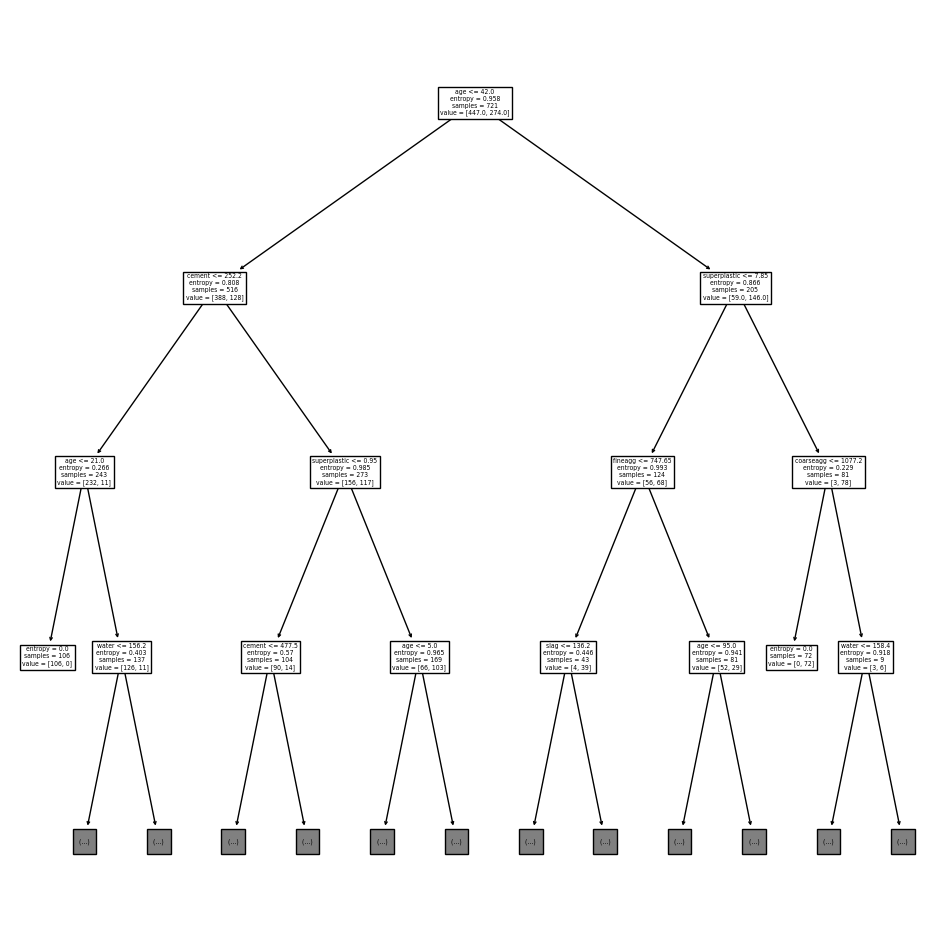

In [1038]:
ax = subplots(figsize=(12, 12))[1]
best_ = grid.best_estimator_
plot_tree(best_,
          feature_names=feature_names,

          ax=ax);

In [1158]:
print(export_text(clf,
                  feature_names=feature_names,
                  show_weights=True))



|--- age <= 42.00
|   |--- cement <= 252.20
|   |   |--- age <= 21.00
|   |   |   |--- weights: [106.00, 0.00] class: No
|   |   |--- age >  21.00
|   |   |   |--- water <= 156.20
|   |   |   |   |--- superplastic <= 7.65
|   |   |   |   |   |--- weights: [1.00, 0.00] class: No
|   |   |   |   |--- superplastic >  7.65
|   |   |   |   |   |--- superplastic <= 12.20
|   |   |   |   |   |   |--- weights: [0.00, 4.00] class: Yes
|   |   |   |   |   |--- superplastic >  12.20
|   |   |   |   |   |   |--- weights: [1.00, 0.00] class: No
|   |   |   |--- water >  156.20
|   |   |   |   |--- fineagg <= 787.25
|   |   |   |   |   |--- fineagg <= 784.50
|   |   |   |   |   |   |--- cement <= 164.50
|   |   |   |   |   |   |   |--- weights: [43.00, 0.00] class: No
|   |   |   |   |   |   |--- cement >  164.50
|   |   |   |   |   |   |   |--- cement <= 207.75
|   |   |   |   |   |   |   |   |--- coarseagg <= 1006.80
|   |   |   |   |   |   |   |   |   |--- slag <= 240.10
|   |   |   |   |   |   |

In [956]:
print(accuracy_score(y_test,
                     best_.predict(X_test)))
confusion = confusion_table(best_.predict(X_test),
                            y_test)
confusion

0.919093851132686


Truth,No,Yes
Predicted,,
No,194,15
Yes,10,90


The tree first splits on age, at a threshold of 42 days, and then, on cement and superplastic at thresholds of $257.7 kg/m^3$ and $7.7 kg/m^3$ respectively. This indicates that age, cement, and superplastic have an effect on compressive strength. Although the tree has many branches, which makes it less interpretable, the model has a high prediction accuracy of 91.9%.

## X Factor

<b> K Nearest Neighbor Regression <b>

In [1166]:
concrete_data_x = pd.read_csv('concrete.csv')

X = concrete_data_x.drop('strength', axis = 1)
y = concrete_data_x['strength']

(X_train,
 X_test,
 y_train,
 y_test) =train_test_split(X,
                            y,
                            test_size=0.3, # 30 percent 
                            random_state=0)

In [1197]:
clf = KNeighborsRegressor(3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(mean_squared_error(y_test,y_pred))


74.86041718806185


In [1199]:
clf = KNeighborsRegressor(10)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(mean_squared_error(y_test,y_pred))

93.38417686407767


Text(0, 0.5, 'MSE')

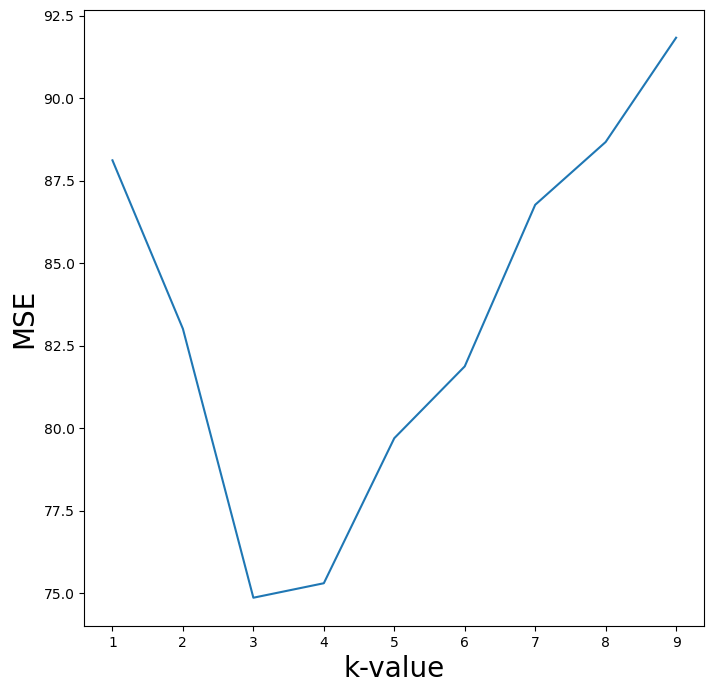

In [1194]:
fig,ax=plt.subplots(figsize=(8,8))
k_list = np.arange(1,10,1)
knn_ = {}
for i in k_list:
    knn = KNeighborsRegressor(n_neighbors=int(i))
    model_knn=knn.fit(X_train,y_train)
    y_knn_pred=model_knn.predict(X_test)
    mse=mean_squared_error(y_test,y_knn_pred)
    knn_[i]=mse

ax.plot(knn_.keys(),knn_.values())
ax.set_xlabel('k-value', fontsize=20)
ax.set_ylabel('MSE' ,fontsize=20)

The graph shows that the best k-value to use for k nearest neighbors is 3. This can be seen by comparing the MSE of the models when k=3 and k=10. The MSE of the model where k=3 is much lower than the MSE of the model when k=10. Having a k-value that is low also indicates that the model has low bias but a high variance. 

## Extension 

I. A regression model of concrete strength as a function of the other input variables could serve as the objective function in an optimization problem. The goal of this optimization would be to maximize the predicted strength of the concrete mixture. The regression model would identify which ingredients to use as decision variables and determine their respective coefficients. The budget for each ingredient would act as constraints in the optimization problem, with a specific constraint defined for each ingredient to ensure costs remain within the budget.
<br>

To address the uncertainty in the regression model, the coefficients used in the optimization problem should be adjusted to produce conservative estimates of concrete strength. This approach ensures that the predicted strength based on the ingredient composition is more likely to be an underestimate rather than an overestimate. By doing so, the solution reduces the risk of overestimating the strength and producing a mixture that fails to meet the desired performance criteria.



II. Classification models can be applied by inputting the amounts of each ingredient for a given mixture and comparing the mixture to previously tested mixtures to predict whether its strength will be above or below 40.0 MPa. As mentioned earlier, an engineer would likely prefer a more conservative strength estimate, prioritizing predictions that are less likely to result in a false positive.
<br>

In this context, a false positive would occur if the model predicts that the concrete mixture will have a strength of at least 40.0 MPa when its actual strength is less than 40.0 MPa. Conversely, a false negative would involve predicting that the concrete's strength is below 40.0 MPa when, in reality, it is above 40.0 MPa.
To incorporate this conservatism into the classification model, you would need to establish the desired confidence level for your predictions. For example, if you require a 95% confidence level, the classification model could be adjusted to predict that the strength is above 40.0 MPa only if the probability of the mixture meeting or exceeding that strength is at least 0.95.


## Limitation of the Study 

The evaluation of the data had constraints due to the lack of data on environmental conditions, mixing ratios, and requirements for stength. Additionally, assumptions of the given data were made to perfrom predictive analysis. <br>

There are multiple environmental factors that can affect the curing process of cement that could impact the strength of the cement. When pouring cement it is important to factor in the environmental conditions, like humidity or temperature. The OLS by forward selection resulted in a negative coefficient for water, thus adding an additional unit of water can cause a deacrease in the strength by a unit.<br>


Another factor that could affect the strength of the cement is the condition in which the mixture was made and poured. There are three common mixing methods: hand mixing, machine mixing, and ready mix. Hand mixing can result in weaker concreate than using a machine mixing because it could result in the mixture not being properly mixed. The pouring process is another important factor that is unknown during the analysis. The strength of concrete is affected by the pouring method. If the concrete is overpoured or unevenly poured the strength of the concrete can be low. 
<br>

Furthermore, assumptions about the data were made regarding the independency of the eight variables. In the analysis it is assumed that the predictors are independent; however, this assumption is not likely to hold, which introduces bias. It is known that the ratio of water and cement can have a great affect on the strngth of the cement, thus creating dependency between water and cement. 
<br>

Lastly, it is assumed that the higher the strength of concrete the better. However in practice, the specification or the strength of concrete might actually have to be contained in a range of values rather than being solely a threshold. For instance, if concrete has a strength that is  too high perhaps it makes the material more brittle which could present other drawbacks in an engineering project. 



## Conclusion

In both the OLS regression model and the LASSO regression model, the slope coefficient for water is negative. This shows that adding water has a negative impact on compressive strength so the amount of water added to a mixture should be minimized. However, water is still a necessary ingredient for mixing cement so some trade-offs are required. Aggregate has a low impact on compressive strength. Forward stepwise selection removes both types of aggregate from the OLS regression model entirely. The LASSO regression model zeroes out fine aggregate and nearly zeroes out coarse aggregate. Slag, ash, and superplastics have positive slope coefficients in both regression models, which shows that these ingredients have a positive relationship with compressive strength. In the LASSO regression model, cement has the largest slope coefficient magnitude, which demonstrates that cement has a strong correlation to high compressive strength. In the OLS regression model, the predictor with the largest slope coefficient magnitude is superplastic, showing that it also has a large impact on compressive strength. The tree first splits on age, and then, on cement and superplastic. This reaffirms that age, cement, and superplastic have a strong effect on compressive strength.

Mixtures with compressive strength above 40 mPa have on average almost double the amount of superplastic as those with compressive strength below 40 mPa as seen in the naive bayes model. Models with compressive strength above 40 mPa have on average significantly more cement and slightly less water. 

In conclusion, the amount of water in the mixture should be minimized. A potential improvement is replacing some water with superplastics in the mixture. A high density of cement should be added.

